1. Set hypotheses
2. Identify necessary information
3. Calculate t value
4. Compare t value to critical t

$\mu$ = population mean

$\bar{x}$ = sample mean

$\sigma$ = sample standard deviation

n = sample size

df = degrees of freedom

diff = $\bar{x} - \mu$

n = $\frac{(z_\alpha + z_\beta)^2\sigma^2}{(\mu_1 - \mu_0)^2}$

$z_\alpha$ = scipy.stats.norm.ppf($\alpha$)

t-statistic = $\frac{\bar{x} - \mu}{\frac{\sigma}{\sqrt{n}}}$




## Questions:
1. **Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?**

2. **Does the employee living close to the customer effect the number of products ordered per month? At what distance?**
  * *Helpful Links*:
    * [geoheat map](https://alcidanalytics.com/p/geographic-heatmap-in-python)
    * [get coordinates](https://pypi.org/project/geopy/)
    * [calculate distance between points](https://www.quantbarbie.com/blog/2018/7/11/calculate-the-distance-between-two-places-in-python)
  * *Data Needed*:
    * Employee ID
    * Employee Longitude
    * Employee Latitude
    * Customer ID
    * Customer Longitude
    * Customer Latitude
    * Month
    * Year
    * Total Number of Products Ordered
  * *Tables*:
    * Employee
    * Order
    * OrderDetail
    * Customer
3. **Which Suppliers are fastest?**
  * *Helpful Links*:
    * ANOVA

  * *Data Needed*:
    * Order Date
    * Shipped Date
    * Time to Process ^
    * Shipper ID
    * Company Name (shipper)
    
    
  * *Tables*:
    * Order
    * Shipper  
4. **Is the business seasonal?**
  * *Helpful Links*:

  * *Data Needed*:
    * Month
    * Year
    * Total Revenue
    * 
    
  * *Tables*:

## Expirmental Design
### 1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?


In [1]:
# import datetime
# before = datetime.datetime.strptime('1998-01-27','%Y-%m-%d')
# now = datetime.datetime.today()
# type(now-before)
# # <type 'datetime.timedelta'>
# (now-before).days
# # 7
# float((now-before).days)/365
# 0.019178082191780823

In [2]:
# Imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
import pandas as pd
import numpy as np
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Connect to database
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
# Use inspect to check database metadata against the ERD we have of the database
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

2019-05-31 11:09:06,273 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-31 11:09:06,275 INFO sqlalchemy.engine.base.Engine ()
2019-05-31 11:09:06,277 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-31 11:09:06,279 INFO sqlalchemy.engine.base.Engine ()
2019-05-31 11:09:06,282 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-31 11:09:06,284 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [4]:
# I created a couple of functions to make it easier to inspect and retreive necessary data

def get_columns_info(table_name):
    """ Print the name and type of each column in the given table.
    
    Args:
        table_name: Name of the table (string)
    """
    cols_list = inspector.get_columns(table_name)
    
    print("Table Name: {}".format(table_name))
    print("")
    for column in cols_list:
        print("Name: {}, \t {}".format(column['name'], column['type']))


def get_column_names(table_name):
    """ Get the name of each column in the given table.
    
    Args:
        table_name: Name of the table (string)
    
    Returns:
        A list of column names
    """
    cols_list = inspector.get_columns(table_name)
    col_names = []
    for column in cols_list:
        col_names.append(column['name'])
    return col_names

get_columns_info('Employee')

2019-05-31 11:09:06,311 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-05-31 11:09:06,313 INFO sqlalchemy.engine.base.Engine ()
Table Name: Employee

Name: Id, 	 INTEGER
Name: LastName, 	 VARCHAR(8000)
Name: FirstName, 	 VARCHAR(8000)
Name: Title, 	 VARCHAR(8000)
Name: TitleOfCourtesy, 	 VARCHAR(8000)
Name: BirthDate, 	 VARCHAR(8000)
Name: HireDate, 	 VARCHAR(8000)
Name: Address, 	 VARCHAR(8000)
Name: City, 	 VARCHAR(8000)
Name: Region, 	 VARCHAR(8000)
Name: PostalCode, 	 VARCHAR(8000)
Name: Country, 	 VARCHAR(8000)
Name: HomePhone, 	 VARCHAR(8000)
Name: Extension, 	 VARCHAR(8000)
Name: Photo, 	 BLOB
Name: Notes, 	 VARCHAR(8000)
Name: ReportsTo, 	 INTEGER
Name: PhotoPath, 	 VARCHAR(8000)


In [5]:
con = engine.connect()

## Discount Rates
### Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

Tables needed:
- Orders
- Order Details
- Products
- Customer

#### Gather and Filter Data
Our first step is to query our database for the tables we might need and save the data into a pandas.DataFrames to work with. At this point we will see which of the tables will be necessary for us to gather the data we need to answer our business questions.

In [6]:
def get_table_data(con, table_name):
    """Get the data from the given table
    
    Args:
        con: Database connection
        table_name: Name of the table (string)
    
    Returns:
        Pandas Dataframe with the data from the table
    """
    table = con.execute("SELECT * FROM '{}'".format(table_name))
    table_df = pd.DataFrame(table.fetchall())
    col = get_column_names('{}'.format(table_name))
    table_df.columns = col
    return table_df


products_df = get_table_data(con, 'Product')
details_df = get_table_data(con, 'OrderDetail')
orders_df = get_table_data(con, 'Order')

products_df.head()
# print(orders.fetchall())

2019-05-31 11:09:06,348 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Product'
2019-05-31 11:09:06,352 INFO sqlalchemy.engine.base.Engine ()
2019-05-31 11:09:06,357 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")
2019-05-31 11:09:06,358 INFO sqlalchemy.engine.base.Engine ()
2019-05-31 11:09:06,361 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'OrderDetail'
2019-05-31 11:09:06,365 INFO sqlalchemy.engine.base.Engine ()
2019-05-31 11:09:06,374 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-05-31 11:09:06,375 INFO sqlalchemy.engine.base.Engine ()
2019-05-31 11:09:06,377 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Order'
2019-05-31 11:09:06,378 INFO sqlalchemy.engine.base.Engine ()
2019-05-31 11:09:06,389 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-05-31 11:09:06,390 INFO sqlalchemy.engine.base.Engine ()


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [7]:
print(details_df.loc[details_df['OrderId'] == 10249])
print(details_df.loc[details_df['ProductId'] == 5])

         Id  OrderId  ProductId  UnitPrice  Quantity  Discount
3  10249/14    10249         14       18.6         9       0.0
4  10249/51    10249         51       42.4        40       0.0
           Id  OrderId  ProductId  UnitPrice  Quantity  Discount
30    10258/5    10258          5      17.00        65      0.20
40    10262/5    10262          5      17.00        12      0.20
111   10290/5    10290          5      17.00        20      0.00
352   10382/5    10382          5      17.00        32      0.00
1022  10635/5    10635          5      21.35        15      0.10
1212  10708/5    10708          5      21.35         4      0.00
1575  10848/5    10848          5      21.35        30      0.00
1840  10958/5    10958          5      21.35        20      0.00
2018  11030/5    11030          5      21.35        70      0.00
2061  11047/5    11047          5      21.35        30      0.25


Filtering details_df by OrderId shows that each record in the `OrderDetail` table describes one product within one order. So, each observation in `Order` table will have one or more observations in the `OrderDetail` table. This means we don't need the `Orders` table as it mainly describes details about the shippment and not what's in the order. 

When looking at all the observations of the same product in the `OrderDetail` table shows that the company didn't always use the price listed in the `Product` table's `UnitPrice`. The quantities and discount levels don't seem to be causing the difference and it's not the average price. So we'll assume the `Product` table's `UnitPrice` to be the suggested price and therefore isn't relevant for what we're trying to acomplish.

This just leaves us with the `OrderDetail` table. We'll drop the columns we won't need to clean up the DataFrame.

In [8]:
df = details_df.drop(['Id'], axis=1)
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [9]:
df['ProductId'].value_counts()
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

#### Scrub Data
Looking at the values we have in each column, there are some discount values that don't have enough observations to make any statistical inferences. We'll drop all rows that contain the following values:
- 0.01
- 0.02
- 0.03
- 0.04
- 0.06

In [10]:
drop_list = [0.01, 0.02, 0.03, 0.04, 0.06]
df = df[~df['Discount'].isin(drop_list) ]
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [11]:
treatment = df.loc[df['Discount'] != 0]
control = df.loc[df['Discount'] == 0]
treatment['Discount'].value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

In [ ]:
# print(np.mean(treatment.sample(n=40)))

# def get_pop_mean(group, size=2000):
#     """Get the population mean by using the central limit theorem
    
#     Args:
#         group: (pd.Series) observations, must be numerical
#         size: (int) size of distribution
    
#     Returns:
#         float: population mean
#     """
#     xbars = []
#     for i in range(size):
#         xbars.append(np.mean(group.sample(n=40))

#### Form Hypothesis

Now that we have our treament and control datasets, we can execute our hypothesis test.

$H_o: \mu_t = \mu_c$

$H_a: \mu_t > \mu_c$

$\alpha$ = 0.05

#### Conduct Experiment
We'll take a sample from our control and treatment groups and run a one-sided, two-sample hypothesis test with an alpha level of 0.05.

In [2]:
sample_t = treatment.sample(n = 50, random_state=10)
sample_c = control.sample(n = 50, random_state=10)
results = stats.ttest_rel(sample_t['Quantity'], sample_c['Quantity'])
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("reject null hypothesis, mean of {} is greater than mean of {}".format('Discounted Quantities','Nondiscounted Quantities'))
else:
    print("fail to reject null hypothesis")


NameError: name 'treatment' is not defined

#### Analyze Results
We have significant evidence to reject the null hypothsis that the mean quanitites of discount orders is equal to the mean quantities on nondiscounted orders. 

#### 
**Determine if the level of discount effects quantities purchased**
Now that we have accepted that discounts do increase the quantity of items purchased, we need to figure out at what discount level is the effect most significant. We'll start with an ANOVA test to figure out if there is a difference in effect between the different levels of discounts.


#### Form Hypothesis
$H_o: \mu_{0.05} = \mu_{0.10} = \mu_{0.15} = \mu_{0.20} = \mu_{0.25}$ 

$H_a: \mu_{0.05} != \mu_{0.10} != \mu_{0.15} != \mu_{0.20} != \mu_{0.25}$ 

#### Sample Different Discount Rates

In [13]:
five = treatment.loc[treatment['Discount'] == 0.05]
ten = treatment.loc[treatment['Discount'] == 0.10]
fifteen = treatment.loc[treatment['Discount'] == 0.15]
twenty = treatment.loc[treatment['Discount'] == 0.20]
twentyfive = treatment.loc[treatment['Discount'] == 0.25]

data = pd.DataFrame()

for group, name in [(five, '0.05'), (ten, '0.10'), (fifteen, '0.15'), (twenty, '0.20'), (twentyfive, '0.25')]:
    group = group.sample(n=50, random_state=10)
    data[name] = group.Quantity.reset_index(drop=True)
data.head()

,0.05,0.10,0.15,0.20,0.25
0,12,20,24,40,20
1,28,18,70,55,2
2,24,18,40,6,12
3,8,15,10,30,20
4,2,10,16,45,30


/Users/joe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


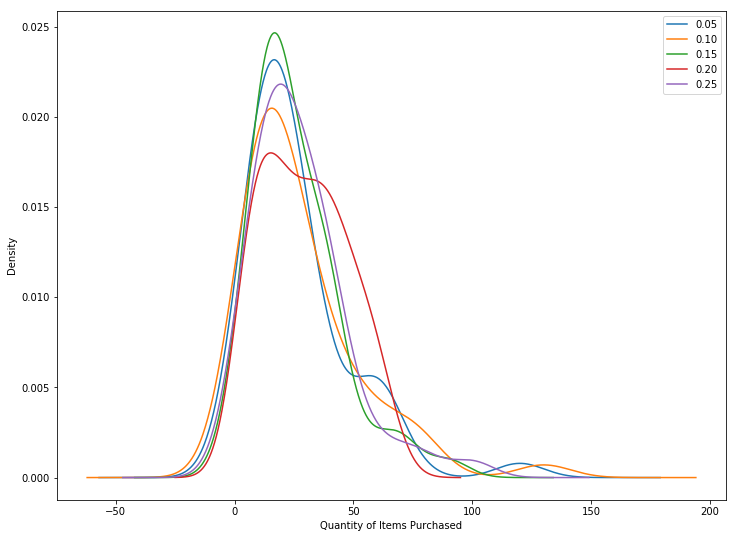

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12,9))
for i in data.columns:
    data[i].plot(kind='density')
plt.legend()
plt.xlabel('Quantity of Items Purchased')
fig.show()

#### Conduct Experiment

In [15]:
stats.f_oneway(data['0.05'], data['0.10'], data['0.15'], data['0.20'], data['0.25'])

F_onewayResult(statistic=0.22583337048873584, pvalue=0.92379289841810175)

#### Analyze Results
Our F-statistic of 0.2258 suggests the between-groups variance is roughly 1/4 of the within-group variance. We fail to reject the null hypothesis of equal mean values  due to the p value being > 0.05. 
### Conclusion
These results aren't surprising considering the density plots of our samples. They are visually close to identical so our recommendation is to stick with low levels of discounts as there is no evidence to say that increasing the discount level will increase the quantity bought, so it just reduces the revenue earned.

## Does the employee living close to the customer effect the number of products ordered per year? At what distance?
* *Helpful Links*:
    * [geoheat map](https://alcidanalytics.com/p/geographic-heatmap-in-python)
    * [get coordinates](https://pypi.org/project/geopy/)
    * [calculate distance between points](https://www.quantbarbie.com/blog/2018/7/11/calculate-the-distance-between-two-places-in-python)
* *Data Needed*:
    * Employee ID x
    * Employee Longitude
    * Employee Latitude
    * Customer ID
    * Customer Longitude
    * Customer Latitude
    * Month
    * Year
    * Total Number of Products Ordered
* *Tables*:
    * Employee
    * Order
    * OrderDetail
    * Customer


In [31]:
# Get data
employee = get_table_data(con, 'Employee')
# drop unnecssary column
employee = employee.drop(['LastName', 'FirstName', 'Title', 'TitleOfCourtesy', 'BirthDate', 'HireDate', 'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo', 'PhotoPath'], axis=1)
# import geopy.geocoders
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="northwind hypothesis testing")
# location = geolocator.geocode("{} {} {}".format(employee.Address[0], employee.City[0], employee.Country[0]))
# print("{} {} {}".format(employee.Address[0], employee.City[0], employee.Country[0]))
# print(location.address)
# print((location.latitude, location.longitude))

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("{} {}".format('6140 Rockhill Rd', 'Kansas City'))
print(location.address)

2019-05-31 11:54:37,974 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Employee'
2019-05-31 11:54:37,975 INFO sqlalchemy.engine.base.Engine ()
6140, Rockhill Road, Western 49/63, Country Club Plaza, Kansas City, Jackson County, Missouri, 64110, USA


In [21]:
employee.head(3)

,Id,Address,City,Region,PostalCode,Country
0,1,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA
1,2,908 W. Capital Way,Tacoma,North America,98401,USA
2,3,722 Moss Bay Blvd.,Kirkland,North America,98033,USA


In [168]:
def compute_n(alpha, beta, mu_0, mu_1, var):
    """ Compute the sample size necessary to gain statistical significance
    
    Args:
        alpha: acceptable level of type I error
        beta: acceptable level of type II error
        mu_0: population mean
        mu_1: sample mean
        var: sample variancel
    
    Returns:
        int of the sample size needed for the acceptable levels of alpha and beta
    """
    z_alpha = stats.norm.ppf(alpha)
    z_beta = stats.norm.ppf(beta)
    num = ((z_alpha+z_beta)**2)*var
    den = (mu_1 - mu_0)**2
    return int(num / den)


def get_pop_mean(data, column):
    """ Get the population mean
    
    Args:
        data: Pandas DataFrame 
            The dataset in question
        column: String 
            The name of the column in question
    
    Returns: Float
        The population mean
    """
    sample_means = []
    for i in range(1000):
        sample = data.sample(n=50, replace=True)
        sample_means.append(np.mean(sample[column]))
    plt.hist(sample_means)
    plt.show()
    return np.mean(sample_means)


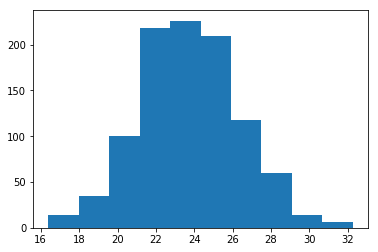

23.759040000000002

In [169]:
get_pop_mean(details_df, 'Quantity')

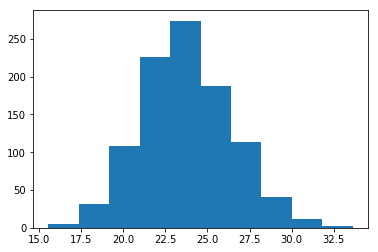

mu: 23.77646,
std_dev: 21.778369400333304
x_bar: 23.16
n: 354
df: 353


In [170]:
mu = get_pop_mean(details_df, 'Quantity')
sample = details_df.sample(n=100)
std_dev = sample['Quantity'].std()
x_bar = np.mean(sample.Quantity)
n = compute_n(0.05, 0.2, mu, x_bar, std_dev)
df = n - 1
# t_val = stats.ttest_1samp()
# t_stat = stats.t_stat()
print("""mu: {},
std_dev: {}
x_bar: {}
n: {}
df: {}""".format(mu, std_dev, x_bar, n, df))


## Is the business seasonal?
  * *Helpful Links*:

  * *Data Needed*:
    * Month
    * Year
    * Total Revenue

In [32]:
orders = get_table_data(con, 'Order')
details = get_table_data(con, 'OrderDetail')

2019-05-31 12:21:14,642 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'Order'
2019-05-31 12:21:14,643 INFO sqlalchemy.engine.base.Engine ()
2019-05-31 12:21:14,652 INFO sqlalchemy.engine.base.Engine SELECT * FROM 'OrderDetail'
2019-05-31 12:21:14,653 INFO sqlalchemy.engine.base.Engine ()


1. Calculate the detail revenue
2. determine month
3. determine year
4. GROUPBY month, year SUM revenue
5. AVG revenue GROUPBY month

## Next Question